  # Evolution de la part de la production d'éléctricité renouvable dans la consommation globale électrique française de 2013 à 2021¶

## importation des différents modules

In [2]:
import re
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

_Configuration de l'affichage des données:_ aucun chiffre après la virgule

In [3]:
##precision floats
pd.options.display.float_format = '{:,.0f}'.format

# Origine des données

**Consommation électrique**  
Les données de l'évolution de la consommation d'éléctricité au cours du temps sont disponibles sur : [**data_gouv_conso**](https://www.data.gouv.fr/fr/datasets/consommation-quotidienne-brute-2012-a-2021/#_).  
Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à la consommation électrique quotidienne par demi-heure en MW. L'URL est: https://opendata.reseaux-energies.fr/explore/dataset/consommation-quotidienne-brute/download?format=csv&timezone=Europe/Berlin&use_labels_for_header=false

**Production électrique**  
En parallèle, les données de l'évolution de la production d'électricité hydraulique, solaire, éolienne et bio-énergie au cours du temps sont disponibles sur : [**data_gouv_prod**](https://www.data.gouv.fr/fr/datasets/production-quotidienne-delectricite-par-filiere-depuis-janvier-2013/#_).  
Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à la production électrique quotidienne par demi-heure en MW. L'URL est: https://opendata.reseaux-energies.fr/explore/dataset/production-quotidienne-filiere/download?format=csv&timezone=Europe/Berlin&use_labels_for_header=false

## Téléchargemet et configuration des données
**NB**: on séléctionne uniquement les colonnes qui nous intéressent pour la suite de l'étude

### Consommation électrique

In [4]:
#upload electric consumption:
conso_elec= pd.read_csv("https://opendata.reseaux-energies.fr/explore/dataset/consommation-quotidienne-brute/download?format=csv&timezone=Europe/Berlin&use_labels_for_header=false", sep=';',
                       usecols=[1,2,8])

In [5]:
# config & convert date to datetime
elec_conso = conso_elec.rename(columns={'consommation_brute_electricite_rte':'conso_elec'}).dropna().copy()

elec_conso['date'] = pd.to_datetime(elec_conso['date'])#, format='%d/%m%/%Y')

elec_conso = elec_conso.sort_values('date')
print(elec_conso.dtypes)
elec_conso.tail()

date          datetime64[ns]
heure                 object
conso_elec           float64
dtype: object


date  heure  conso_elec
31626 2021-12-02  08:00       5,647
31625 2021-12-02  08:00       5,641
31624 2021-12-02  08:00      13,486
31532 2021-12-02  12:00       6,090
31818 2021-12-02  00:00      12,020

On agglomère les données en un tableau de consommation quotidienne en GW

In [6]:
#daily consumption & convert to GW
elec_conso_ = elec_conso.groupby('date')['conso_elec'].sum().reset_index()

elec_conso_['conso_elec'] = elec_conso_['conso_elec'].map(lambda x: x/10**3)

elec_conso_

date  conso_elec
0    2012-01-01       2,473
1    2012-01-02       4,012
2    2012-01-03       3,012
3    2012-01-04       2,186
4    2012-01-05       2,114
5    2012-01-06       2,287
6    2012-01-07       1,874
7    2012-01-08       2,192
8    2012-01-09       1,973
9    2012-01-10       2,375
10   2012-01-11       2,622
11   2012-01-12       3,279
12   2012-01-13       3,414
13   2012-01-14       3,254
14   2012-01-15       3,265
15   2012-01-16       3,668
16   2012-01-17       3,777
17   2012-01-18       3,771
18   2012-01-19       3,505
19   2012-01-20       3,346
20   2012-01-21       2,959
21   2012-01-22       2,765
22   2012-01-23       3,184
23   2012-01-24       3,309
24   2012-01-25       3,275
25   2012-01-26       3,285
26   2012-01-27       3,321
27   2012-01-28       3,129
28   2012-01-29       3,151
29   2012-01-30       3,700
...         ...         ...
3317 2021-02-19       2,977
3318 2021-02-20       2,584
3319 2021-02-21       2,449
3320 2021-02-22       2,767
3321 2021-02-23       2,693
3322 2021-02-24       2,627
3323 2021-02-25       2,654
3324 2021-02-26       2,718
3325 2021-02-27       2,625
3326 2021-02-28       2,571
3327 2021-03-01       3,237
3328 2021-03-02       2,938
3329 2021-04-01       3,654
3330 2021-04-02       3,009
3331 2021-05-01       3,772
3332 2021-05-02       2,937
3333 2021-06-01       3,778
3334 2021-06-02       2,740
3335 2021-07-01       3,821
3336 2021-07-02       2,829
3337 2021-08-01       3,824
3338 2021-08-02       3,403
3339 2021-09-01       3,614
3340 2021-09-02       3,589
3341 2021-10-01       3,509
3342 2021-10-02       3,639
3343 2021-11-01       3,863
3344 2021-11-02       3,764
3345 2021-12-01       3,711
3346 2021-12-02       3,787

[3347 rows x 2 columns]

**NB:** On peut s'étonner de retrouver des consommations électriques futuristes !!

### Production électrique

In [7]:
#upload electric production:
prod_elec= pd.read_csv("https://opendata.reseaux-energies.fr/explore/dataset/production-quotidienne-filiere/download?format=csv&timezone=Europe/Berlin&use_labels_for_header=false",
                       sep=';', usecols=[1,2,3,8,10,11,12])


In [8]:
# config & convert date to datetime
cols_prod = ['date', 'heure', 'prod_totale', 'hydrau', 'solaire', 'eolien', 'bio']

elec_prod = prod_elec.copy()
elec_prod.columns = cols_prod

elec_prod['date'] = pd.to_datetime(elec_prod['date'])#, format='%d/%m%/%Y')

elec_prod = elec_prod.sort_values('date')
print(elec_prod.dtypes)
elec_prod.tail()

date           datetime64[ns]
heure                  object
prod_totale             int64
hydrau                  int64
solaire                 int64
eolien                  int64
bio                     int64
dtype: object


date  heure  prod_totale  hydrau  solaire  eolien   bio
65163  2021-02-28  23:00        61588   10180        1    6252  1171
104255 2021-02-28  00:00        62371    7763        2    7973  1190
104256 2021-02-28  01:00        60730    8398        1    7782  1190
78653  2021-02-28  13:00        59903    5641     6283    5105  1192
35779  2021-02-28  22:00        60979    9767        1    6546  1171

In [ ]:
On agglomère les données en un tableau de production quotidienne en GW

In [10]:
#daily prod & convert to GW:
elec_prod_ = elec_prod.groupby('date')[['prod_totale', 'hydrau', 'solaire', 'eolien', 'bio']].sum().reset_index()

elec_prod_[['prod_totale', 'hydrau', 'solaire', 'eolien', 'bio']] = elec_prod_[['prod_totale', 'hydrau', 'solaire', 'eolien', 'bio']].apply(lambda x: x/10**3)

print(elec_prod_.shape)
elec_prod_.head()

(2981, 6)


date  prod_totale  hydrau  solaire  eolien  bio
0 2013-01-01        3,046     328        6     126   35
1 2013-01-02        3,440     422       13      68   34
2 2013-01-03        3,502     439       10      78   35
3 2013-01-04        3,448     415        7      49   36
4 2013-01-05        3,297     386        7      44   37

### Fusion des 2 fichiers

In [12]:
elec_df = pd.merge(elec_prod_, elec_conso_, on='date', how='left')

print(elec_df.shape)
elec_df[560:568]

(2981, 7)


date  prod_totale  hydrau  solaire  eolien  bio  conso_elec
560 2014-07-15        2,859     457       56      21   38       2,244
561 2014-07-16        2,878     450       59      14   38       2,326
562 2014-07-17        2,935     453       60      43   37       2,368
563 2014-07-18        2,916     429       51      66   39       2,359
564 2014-07-19        2,677     365       40      90   40       2,057
565 2014-07-20        2,518     324       30      48   39       1,865
566 2014-07-21        2,807     416       41      90   38       2,206
567 2014-07-22        2,873     423       43      92   38       2,290

Vérifions qu'il n'y a pas de données manquantes

In [13]:
print(pd.isnull(elec_df).sum())

elec_df[pd.isna(elec_df['conso_elec'])]

date            0
prod_totale     0
hydrau          0
solaire         0
eolien          0
bio             0
conso_elec     20
dtype: int64


date  prod_totale  hydrau  solaire  eolien  bio  conso_elec
2924 2021-01-03        3,161     289       23     113   53         nan
2925 2021-01-04        3,478     414       17     126   53         nan
2926 2021-01-05        3,609     512       13     121   54         nan
2927 2021-01-06        3,613     501       21      78   54         nan
2928 2021-01-07        3,699     534       31      74   54         nan
2929 2021-01-08        3,761     563       39      81   54         nan
2930 2021-01-09        3,634     386       28     207   54         nan
2931 2021-01-10        3,514     295       37     201   54         nan
2932 2021-01-11        3,796     499       39     209   53         nan
2933 2021-01-12        3,924     466       18     439   53         nan
2955 2021-02-03        3,500     460       32     476   52         nan
2956 2021-02-04        3,419     526       27     148   53         nan
2957 2021-02-05        3,382     510       29      95   55         nan
2958 2021-02-06        3,141     509       14     150   55         nan
2959 2021-02-07        3,094     475       32     195   55         nan
2960 2021-02-08        3,366     595       27      65   52         nan
2961 2021-02-09        3,635     631       26     173   50         nan
2962 2021-02-10        3,725     610       41     300   51         nan
2963 2021-02-11        3,799     638       50     281   52         nan
2964 2021-02-12        3,786     598       20     398   53         nan

Des données de consommation sont manquantes pour les mois de janvier et février 2021. On restreind notre plage d'étude aux années 2013 à 2020.

In [15]:
elec_df = elec_df.set_index('date').loc['2012-01-01':'2020-12-31']

print(elec_df.shape[0])
elec_df.tail()

2922


prod_totale  hydrau  solaire  eolien  bio  conso_elec
date                                                             
2020-12-27        3,123     295       11     518   53       2,983
2020-12-28        3,325     430       18     367   51       3,093
2020-12-29        3,273     384       22     206   51       3,130
2020-12-30        3,195     336       26     164   51       3,168
2020-12-31        3,183     323       18     168   52       3,128

On crée les colonnes "année", "mois", "jour_semaine" pour chaque date

In [18]:
elec_df['annee'] = elec_df.index.year
elec_df['mois'] = elec_df.index.month
elec_df['jour_sem'] = elec_df.index.weekday_name

elec_df[768:774]

prod_totale  hydrau  solaire  eolien  bio  conso_elec  annee  \
date                                                                       
2015-02-08        3,622     384       27     190   45       1,797   2015   
2015-02-09        3,773     461       36      55   44       2,261   2015   
2015-02-10        3,828     467       34      68   45       2,411   2015   
2015-02-11        3,821     449       38      56   46       2,663   2015   
2015-02-12        3,791     436       30      31   46       3,098   2015   
2015-02-13        3,789     400       25     210   46       3,453   2015   

            mois   jour_sem  
date                         
2015-02-08     2     Sunday  
2015-02-09     2     Monday  
2015-02-10     2    Tuesday  
2015-02-11     2  Wednesday  
2015-02-12     2   Thursday  
2015-02-13     2     Friday

### conversion au format csv

In [19]:
elec_df.to_csv('electricite_conso_prod_renouvelable_france_2013_2020_042021.csv')

# Analyses

## Statisiques

Quelques statistiques au travers de la fonction describe

In [20]:
elec_df[['conso_elec', 'prod_totale', 'hydrau', 'solaire', 'eolien', 'bio',]].describe()

conso_elec  prod_totale  hydrau  solaire  eolien   bio
count       2,922        2,922   2,922    2,922   2,922 2,922
mean        2,586        2,921     348       48     137    47
std           521          475     106       28     106     7
min         1,692        1,826     101        3       7    25
25%         2,208        2,563     261       25      61    42
50%         2,419        2,803     350       43     104    48
75%         2,991        3,315     430       66     180    52
max         4,301        4,211     607      134     588    64

**Remarques:** 
    - la production d'électricité à partir d'énergies renouvelables se caractérise par une forte variabilité annuelle. On observe une forte variabilité (min vs max) de ces productions sur la période considérée. Pour confirmation, on observera l'évolution intra-annuelle.
    - L'évolution du potentiel de production éolien semble avoir ete plus imortant que celui du solaire (différence min-max).

## Saisonnalité

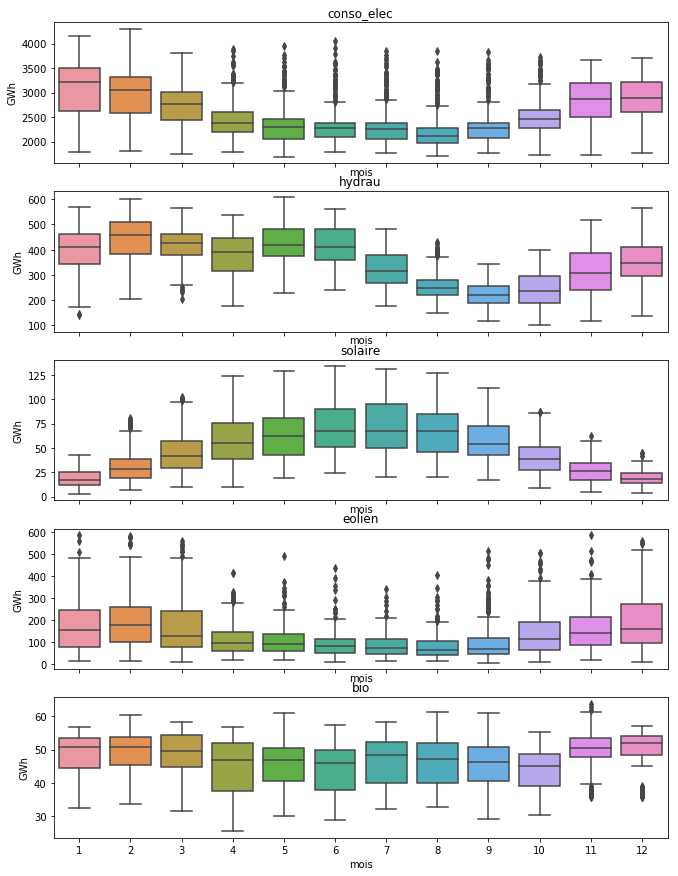

In [21]:
fig, axes = plt.subplots(5, 1, figsize=(11, 15), sharex=True)
for name, ax in zip(['conso_elec', 'hydrau', 'solaire', 'eolien', 'bio'], axes):
    sns.boxplot(data=elec_df, x='mois', y=name, ax=ax)
    ax.set_ylabel('GWh')
    ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
#if ax != axes[-1]:
#    ax.set_xlabel('')

**Commentaires:** 
    - confirmation de la saisonnalité de la consommation électrique, avec des pics durant les mois les plus froids (novembre à mars),  
    - Les productions éoliennes, solaires ou hydroéléctriques varient au cours de l'année avec une saisonnalité différente selon la production considérée:  
        * hydroélectrique : production moindre sur la période de juillet à octobre que nous pouvons décomposer en 2 phases:  
            # juillet - août : période traditionnelle de sécheresse  
            # septembre - octobre : reconstitution des réserves de stockage hydriques
        * solaire : saisonnalité "classique" lié à la saisonnalité annuelle de l'ensoleillement
        * éolien : saisonnalité inversée p/r à l'éolien mais moins marquée. On notera un nombre de valeurs mensuelles irrégulières plus important que pour les autres productions, reflet d'un potentiel "éolien" mensuel plus sensible aux fluctuations climatiques (tempête, ...)  
    - La production d'électricité à base de bio énergies peut être considérée comme la seule à âtre régulière tout au long de l'année. 

## Saisonnalité hebdomadaire

''

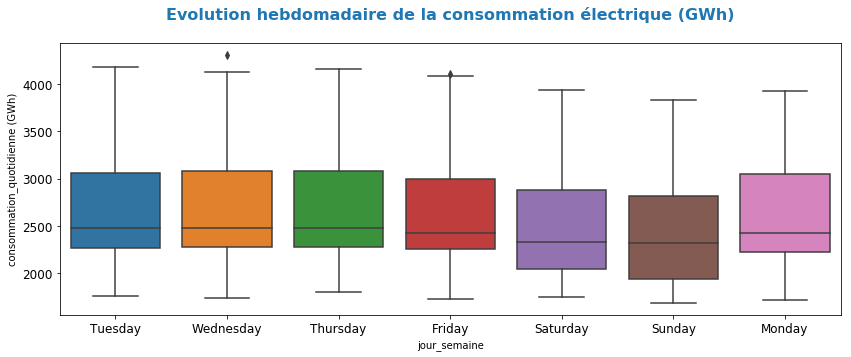

In [22]:
fig, ax = plt.subplots(figsize=(14,5))
ax = sns.boxplot(data=elec_df, x='jour_sem', y='conso_elec')
ax.set_title(f'Evolution hebdomadaire de la consommation électrique (GWh)\n',
             fontweight='bold', fontsize=16, color='C0')
ax.set_ylabel('consommation_quotidienne (GWh)')
ax.set_xlabel('jour_semaine')
plt.yticks(fontsize=12), plt.xticks(fontsize=12)
;

**Remarques:** 
    - la consommation d'électricité est plus faible lors du week-end, mais avec un écart qu'on aurait supposé plus important par rapport aux autres jours de la semaine.  

L'analyse de saisonnalité peut également être conduite par l'[autocorrelation_plot](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html) comme nous le verrons dans quelques instants

## Evolution au cours dela période considérée

**NB_1:** afin d'obtenir une visualisation plus apropriée des évolutions annuelles, nous allons modifier la fréquence des données (**resample**) en passant d'une fréquence quotidienne à une fréquence mensuelle (**downsampling**)  
**NB_2:** la donnée mensuelle sera notifiée "nan" si pour la colonne considérée, le mois comporte moins de 28 données (*min-count=28*)

In [23]:
cols_month = ['prod_totale', 'conso_elec', 'hydrau', 'solaire', 'eolien', 'bio']
elec_month = elec_df[cols_month].resample('M').sum(min_count=28)

elec_month.head()

prod_totale  conso_elec  hydrau  solaire  eolien   bio
date                                                              
2013-01-31      115,031      99,568  13,640      281   2,645 1,105
2013-02-28      104,102      89,522  13,541      447   2,923   995
2013-03-31      103,425      93,263  12,729      673   2,702 1,083
2013-04-30       87,976      76,669  14,253      847   2,976   861
2013-05-31       86,482      79,348  17,016      981   2,304   994

**Graphique de l'évolution de la consommation éléctrisue versus la production d'électrcité renouvable**

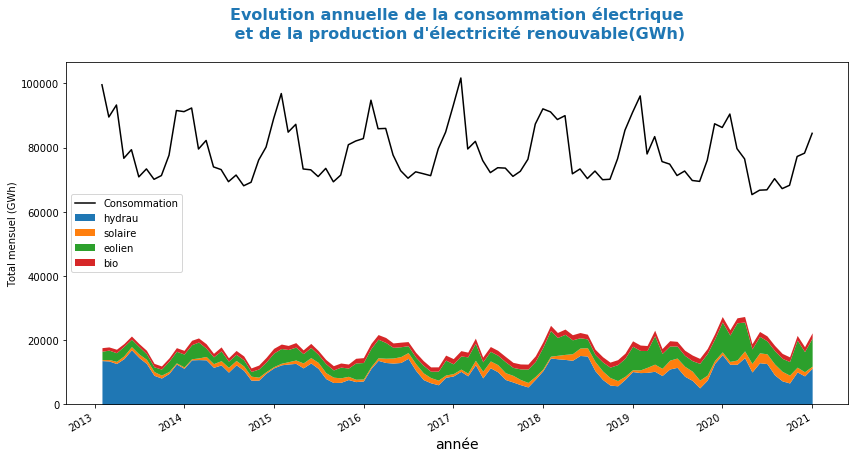

In [24]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14,7))
ax.plot(elec_month['conso_elec'], color='black', label='Consommation')
elec_month[['hydrau', 'solaire', 'eolien', 'bio']].plot.area(ax=ax, linewidth=0)
ax.set_title(f"Evolution annuelle de la consommation électrique\n et de la production d'électricité renouvable(GWh)\n",
             fontweight='bold', fontsize=16, color='C0')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_xlabel('année', fontsize=14)
ax.legend()
ax.set_ylabel('Total mensuel (GWh)');

**Remarques:**  
On observe :  
    * la saisonnalité des différents items (en dehors de la bio-énergie),  
    * la relative constance de la consommation électrique au cours des années, voire sa légère tendance à la baisse (à confirmer),  
    * la part croissante de l'éolien, et dans une moindre mesure du solaire, dans la contribution à la production d'éléctricité.

**Observation de l'évolution de la part des énergies renouvelables dans la consommation éléctrique**

"Resamplons" par année

In [25]:
elec_year = elec_df[cols_month].resample('A').sum()

#set index on year:
elec_year = elec_year.set_index(elec_year.index.year)

elec_year

prod_totale  conso_elec  hydrau  solaire  eolien    bio
date                                                         
2013    1,096,960     984,370 149,301    9,093  31,825 12,404
2014    1,076,425     924,697 134,721   11,638  34,118 15,020
2015    1,089,261     946,306 117,043   14,573  42,189 15,833
2016    1,058,694     960,641 126,719   16,522  41,836 17,423
2017    1,054,369     958,089 106,027   17,987  48,195 18,877
2018    1,093,297     951,042 134,820   21,166  56,262 19,092
2019    1,070,779     940,954 119,004   24,204  67,632 19,321
2020      995,090     891,236 128,795   25,295  78,498 18,794

Calcul du ratio "renouvelables/consommation"

In [26]:
elec_year['renouvelables'] = [w+x+y+z for w,x,y,z in zip(elec_year['hydrau'], elec_year['solaire'], elec_year['eolien'],
                                                         elec_year['bio'])]

elec_year['renouvelables/consommation'] = [(x/c)*100 for x,c in zip(elec_year['renouvelables'], elec_year['conso_elec'])]

elec_year

prod_totale  conso_elec  hydrau  solaire  eolien    bio  renouvelables  \
date                                                                           
2013    1,096,960     984,370 149,301    9,093  31,825 12,404        202,622   
2014    1,076,425     924,697 134,721   11,638  34,118 15,020        195,496   
2015    1,089,261     946,306 117,043   14,573  42,189 15,833        189,637   
2016    1,058,694     960,641 126,719   16,522  41,836 17,423        202,499   
2017    1,054,369     958,089 106,027   17,987  48,195 18,877        191,087   
2018    1,093,297     951,042 134,820   21,166  56,262 19,092        231,339   
2019    1,070,779     940,954 119,004   24,204  67,632 19,321        230,162   
2020      995,090     891,236 128,795   25,295  78,498 18,794        251,382   

      renouvelables/consommation  
date                              
2013                          21  
2014                          21  
2015                          20  
2016                          21  
2017                          20  
2018                          24  
2019                          24  
2020                          28

*Tracé du graphique*

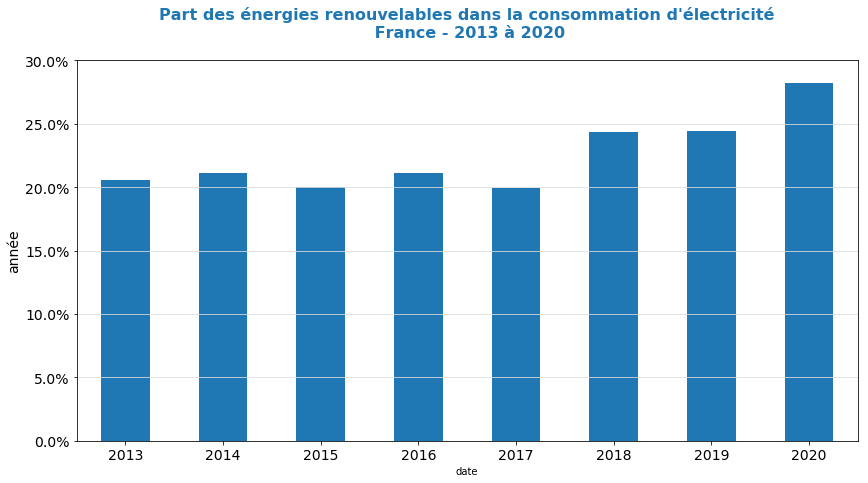

In [27]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(14,7))
ax = elec_year['renouvelables/consommation'].plot.bar(color='C0')
ax.set_ylabel('ratio', fontsize=14), ax.set_ylabel('année', fontsize=14)
ax.set_ylim(0, 30)
ax.set_title(f"Part des énergies renouvelables dans la consommation d'électricité\n France - 2013 à 2020\n",
             fontweight='bold', fontsize=16, color='C0')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.grid(axis='y', c='gainsboro')
plt.xticks(fontsize=14, rotation=0), plt.yticks(fontsize=14);

**Remarques:**  
    * la part de la production électrique "renouvelable" dans la consommation globale d'électrcité est passée de 20% en 2013 à 28% en 2020  
    * personnellement assez surpris par la part de la production électrique renouvelable dans la consommation électrique globale -> légère surestimation ? La production hydroélectrique est fortement contributrice

## Tendances

**NB_1** utilisons la moyenne mobile (**methode *rolling()***) pour visualiser les tendances d'évolution de chaque production "renouvelbale" au cours des années  
**NB_2:** examinons les moyennes mobiles sur la saisonnalité annuelle

Création de la colonne **"renouvelables"**, cumul des productions hydro+éolien+solaire+bio

In [28]:
elec_df['renouvelables'] = [w+x+y+z for w,x,y,z in zip(elec_df['hydrau'], elec_df['solaire'], elec_df['eolien'],
                                                       elec_df['bio'])]

cols_month.append('renouvelables')

In [29]:
elec_yearmob = elec_df[cols_month].rolling(window=365, center=True).mean()

*Tracé du graphique de tendance*

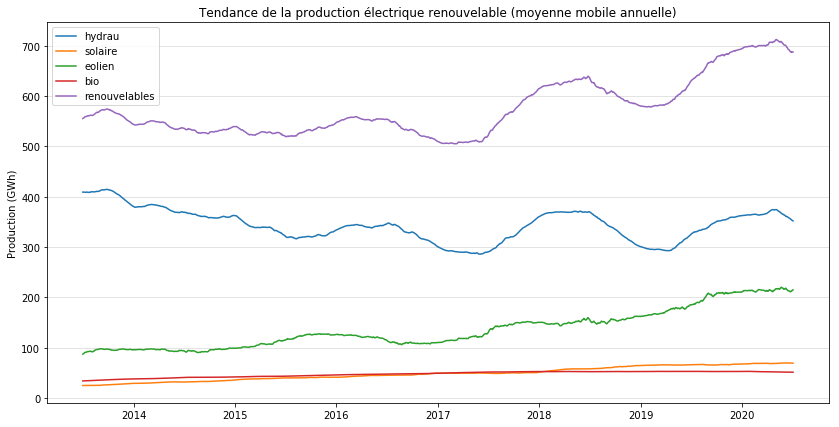

In [30]:
fig, ax = plt.subplots(figsize=(14,7))
for x in ['hydrau', 'solaire', 'eolien', 'bio', 'renouvelables']:
    ax.plot(elec_yearmob[x], label=x)
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.legend()
    ax.set_ylabel('Production (GWh)')
    ax.set_title(f"Tendance de la production électrique renouvelable (moyenne mobile annuelle)")
    plt.grid(axis='y', c='gainsboro');

**Conclusion:**  
    * Conformément aux annonces politiques, la production d'électricité "renouvelable" augmente au cours des années...,   
    * le principal contributeur de cette hausee est l'énergie éolienne et dans une moindre mesure la production éolienne et les bioénergies  
    * la production hydroélectrique a tendance à régresser au cours des années (lien avec la fréquence des sécheresses sur la même période ?) mais participe toujours à hauteur de 50% dans la production d'électricité renouvelable.